# Machine Learning with Church Music 
#### By Jake Bodea


## Introduction
As a worship leader at Agape Church of Orange County, I found difficulty in picking a worship set at times. I dreamed of a program that would make that process easier. Upon finding that our church's organizational software, Planning Center, held a data set of our church music data available for download, it dawned on me that the program I envisioned could actually become a reality. 

Part One of this project will focus on cleaning up that poorly-managed data set and expanding on that data, whereas Part Two will demonstrate how machine learning algorithms can help group such data into clusters of similar songs to help streamline the song selection process. 

## Part One: Cleaning and Improving the data 
The first thing that needs to be done before any analysis is collecting the data. Below is some code that downloads my church's Planning Center data. The Python library Pandas converts the csv data from Planning Center into a Data Frame, which is a 2-dimensional table of rows and columns, similar to a spreadsheet on Excel. 

In [1]:
import pandas as pd 
import numpy as np

temp = pd.read_csv("pco_songs.csv")
temp = temp.drop_duplicates()
print("There are currently {} rows of data.".format(temp.shape[0]))

There are currently 565 rows of data.


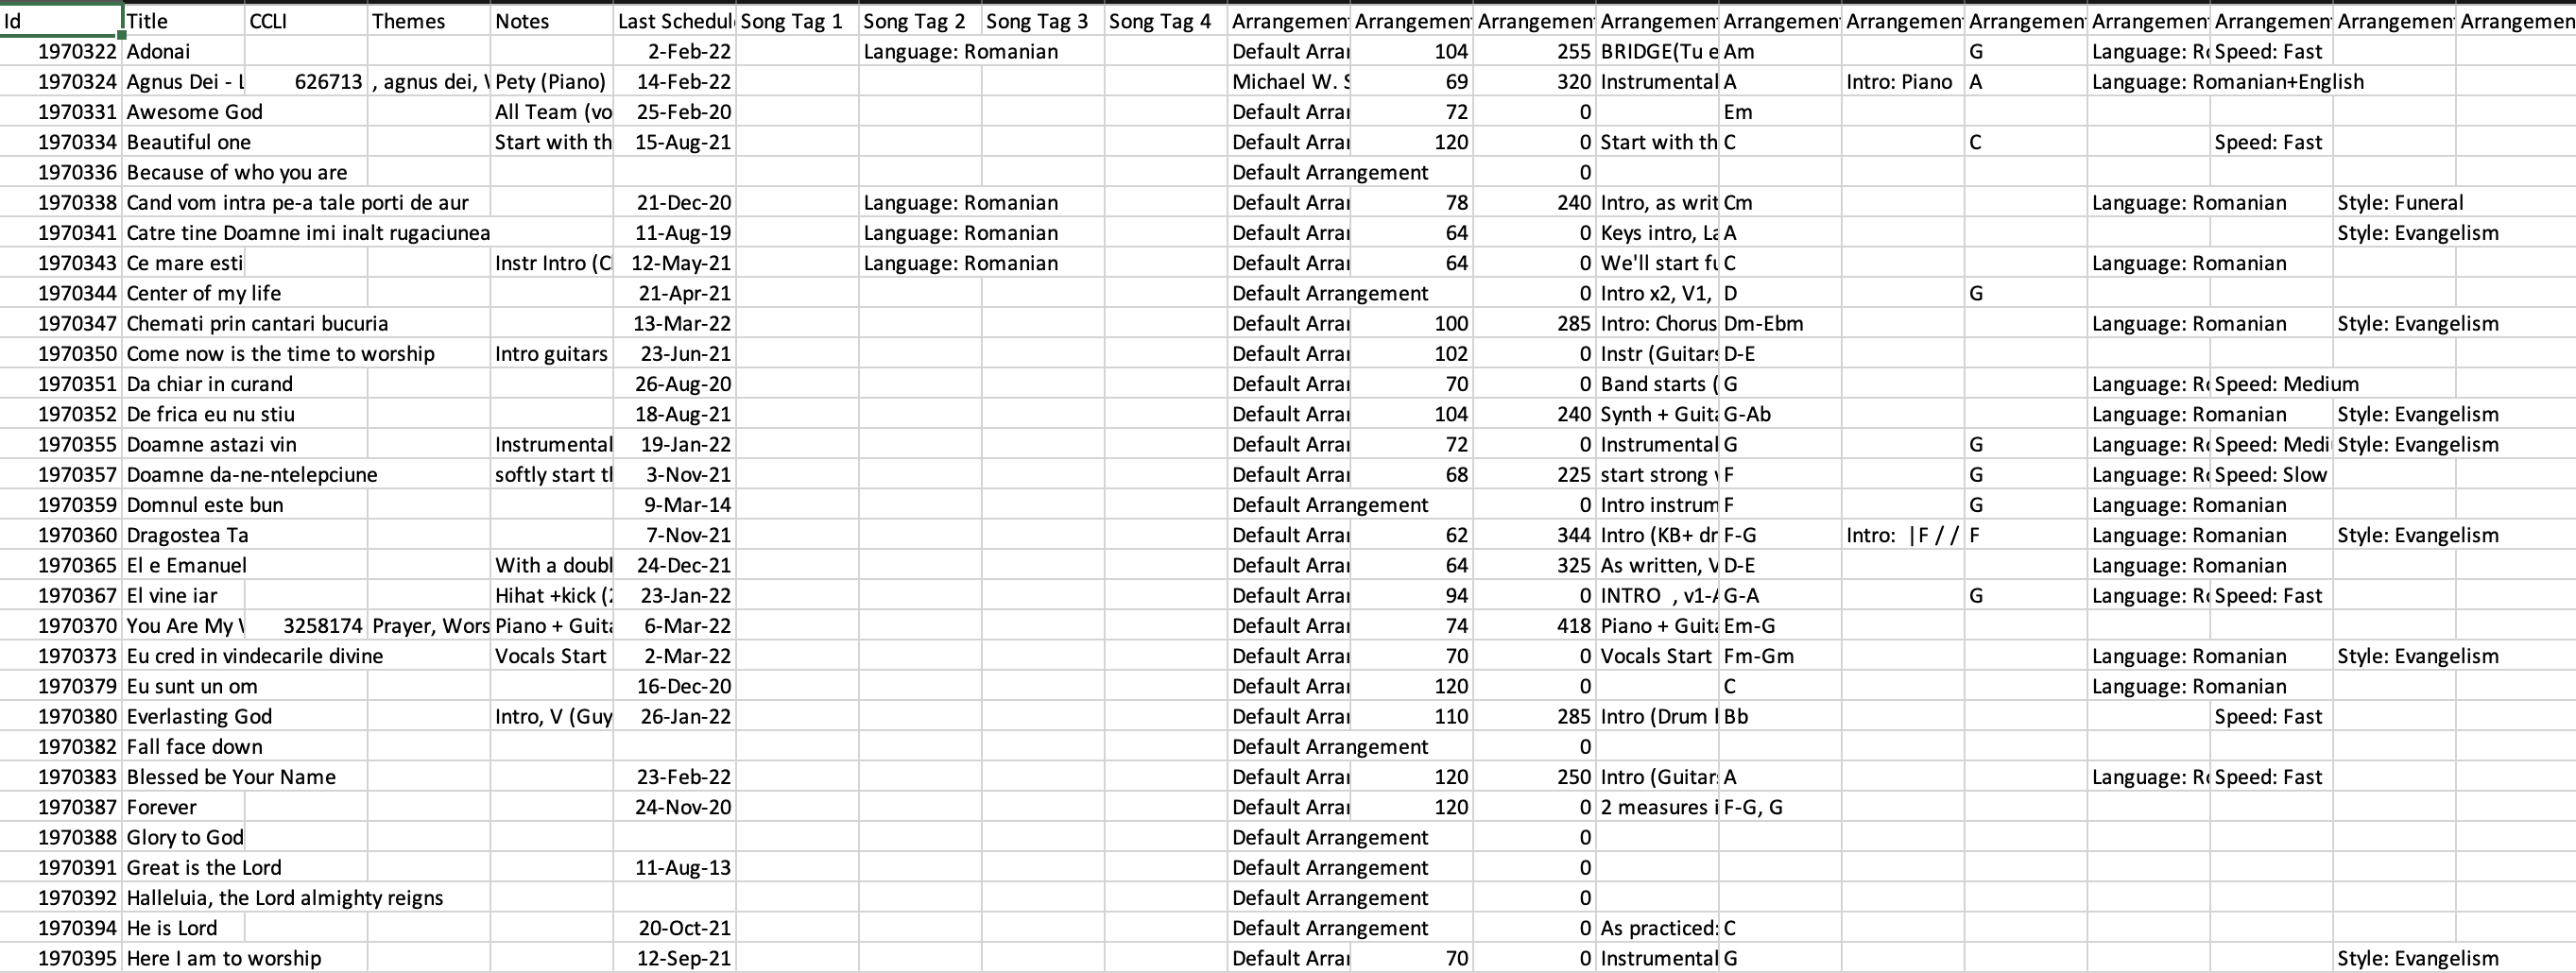


Looking at the above data, it can be seen that there are a lot of variables that have not been inputted consistently, such as "Themes" and "Song Tags". When trying to analyze large sets of data, it is crucial to have a "clean" data set, meaning that there are no empty spaces where data is expected. Unfortunately, it seems that this data set has too many columns with little to no information. Let's take only the Title and BPM data and see what else can be derived. 

*Note: BPM stands for "Beats per Minute" and is a measurement of a song's speed*

In [2]:
df = temp[["Title", "Arrangement 1 BPM"]]
df = df.rename(columns={"Arrangement 1 BPM": "BPM"})
df.head()

Title    BPM
0                    Adonai  104.0
1  Agnus Dei - Lord of All    69.0
2               Awesome God   72.0
3             Beautiful one  120.0
4    Because of who you are    NaN

Let us now limit the data to entries that have a valid BPM ("NaN" refers to "Not a number", and is shown when my church did not input any data for the BPM).

In [3]:
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

Title    BPM
0                                 Adonai  104.0
1               Agnus Dei - Lord of All    69.0
2                            Awesome God   72.0
3                          Beautiful one  120.0
4  Cand vom intra pe-a tale porti de aur   78.0

We now have two variables: an identifying variable, `Title`, and a numeric variable, `BPM`. Given that my church had a multilingual congregation and thus multilingual songs, let us try to explore this data more by trying to figure out the language of each song. 

`LangDetect` is an open source library claiming to use Google's translation features. Notice the implementation below:

In [4]:
import langdetect as lang

df["Language"] = ""
df["Lang Probs"] = df["Title"].apply(lang.detect_langs)

In [5]:
df.head()

Title    BPM Language  \
0                                 Adonai  104.0            
1               Agnus Dei - Lord of All    69.0            
2                            Awesome God   72.0            
3                          Beautiful one  120.0            
4  Cand vom intra pe-a tale porti de aur   78.0            

                                        Lang Probs  
0  [tl:0.8571386056006786, id:0.14286069370907353]  
1   [en:0.8571393258573531, nl:0.1428571257547347]  
2                          [af:0.9999939556167616]  
3  [ro:0.8571402589640329, fr:0.14285972316680953]  
4   [it:0.5713876077958037, pt:0.4285697122261661]

In [ ]:
# since every run of detect or detect_langs is different, 
# this ensures that df["Language"] will just be the most likely language from a single result in string format
i = 0
for lan in df["Lang Probs"]:
    language = str(lan)[1:3]
    if language != "en":
        df["Language"].iloc[i] = "not en"
    else:
        df["Language"].iloc[i] = "en"
    i += 1

In [7]:
df.head()

Title    BPM Language  \
0                                 Adonai  104.0   not en   
1               Agnus Dei - Lord of All    69.0       en   
2                            Awesome God   72.0   not en   
3                          Beautiful one  120.0   not en   
4  Cand vom intra pe-a tale porti de aur   78.0   not en   

                                        Lang Probs  
0  [tl:0.8571386056006786, id:0.14286069370907353]  
1   [en:0.8571393258573531, nl:0.1428571257547347]  
2                          [af:0.9999939556167616]  
3  [ro:0.8571402589640329, fr:0.14285972316680953]  
4   [it:0.5713876077958037, pt:0.4285697122261661]

Notice that there are lots of errors with the `LangDetect` library. Most explicitly is at index 3: "Beautiful One" is considered as Romanian! Also, every time the code is rerun, a different result is outputted (called a nondeterministic algorithm). This makes it really difficult to parse the language without more text. Let's try to automate some lyric data retrieval by web scraping Google search results. 

In [8]:
'''
Below code is commented due to length, see next codeblock for a download of csv file.

import requests
from bs4 import BeautifulSoup

lyrics = df["Title"] # lyrics is a series, not df. needs to be converted 
lyrics = lyrics.to_frame()
lyrics["Text"] = ""
i=0
for i in range(len(lyrics)):
    search = "{} lyrics".format(lyrics["Title"].iloc[i])
    url = f"https://www.google.com/search?&q={search}" 
    req = requests.get(url).text
    sor = BeautifulSoup(req, "html.parser")
    check = type(sor.find("div", class_='hwc'))
    if str(check) != "<class 'NoneType'>":
        words = sor.find("div", class_='hwc').text
        lyrics["Text"].iloc[i] = words
    i += 1

# since "newline" keys are processed as "/n", lets remove that from each instance in lyrics["Text"]
lyrics["Text"] = lyrics["Text"].replace("/n", " ")

lyrics.head()
'''
;

''

**Note:** 
*The above cell takes a long time to run, so instead the output was saved into a separate .csv file that is simply downloaded below*

The code above does the following:
* Google search of '{title} lyrics'
* Looks to see if Google provides lyrics based on the search
* Saves those lyrics to a new variable

Here is a screenshot of what it looks like when Google provides lyrics:

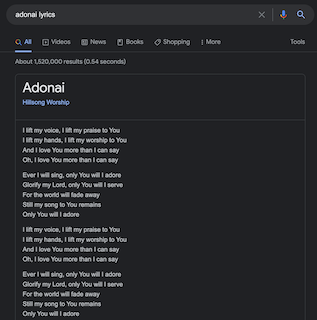

In [9]:
# saved excel of above code so we don't have to wait a long time to do it again, just import csv file
# lyrics.to_excel('lyrics.xlsx', index=False)

In [10]:
lyrics = pd.read_excel('lyrics.xlsx')
lyrics = lyrics.drop_duplicates()
lyrics.head()

Title                                               Text
0                    Adonai  I lift my voice, I lift my praise to You\nI li...
1  Agnus Dei - Lord of All   Alleluia, Alleluia\nFor the Lord God Almighty ...
2               Awesome God  Our God is an awesome God\nHe reigns from heav...
3             Beautiful one  Wonderful, so wonderful\nIs Your unfailing lov...
4    Because of who you are  I worship you Lord\nLord, I love you, Lord\n\n...

Now we can rerun the language detection algorithm based on the lyrics instead of the title. If the lyrics are blank (as in, Google was unable to find lyrics), then the algorithm would look at the title as before. 

In [11]:
lyrics["Language Probs"] = ""

i = 0
for i in range(len(lyrics)):
    if str(lyrics["Text"].iloc[i]) != "nan": # if no lyrics availalbe, use title
        lyrics["Language Probs"].iloc[i] = lang.detect_langs(lyrics["Text"].iloc[i])
    else:
        lyrics["Language Probs"].iloc[i] = lang.detect_langs(lyrics["Title"].iloc[i])
    i+=1
    
lyrics.head()

Title  \
0                    Adonai   
1  Agnus Dei - Lord of All    
2               Awesome God   
3             Beautiful one   
4    Because of who you are   

                                                Text           Language Probs  
0  I lift my voice, I lift my praise to You\nI li...  [en:0.9999962671595386]  
1  Alleluia, Alleluia\nFor the Lord God Almighty ...  [en:0.9999970413285042]  
2  Our God is an awesome God\nHe reigns from heav...  [en:0.9999957372229569]  
3  Wonderful, so wonderful\nIs Your unfailing lov...  [en:0.9999957797556582]  
4  I worship you Lord\nLord, I love you, Lord\n\n...  [en:0.9999978096878703]

In [12]:
lyrics["Language"] = ""

lyrics = lyrics[["Title", "Language", "Language Probs", "Text"]] 
# rearranges df 


i = 0
for lan in lyrics["Language Probs"]:
    language = str(lan)[1:3]
    if language != "en":
        lyrics["Language"].iloc[i] = "not en"
    else:
        lyrics["Language"].iloc[i] = "en"
    i += 1
    
lyrics.head()

Title Language           Language Probs  \
0                    Adonai       en  [en:0.9999962671595386]   
1  Agnus Dei - Lord of All        en  [en:0.9999970413285042]   
2               Awesome God       en  [en:0.9999957372229569]   
3             Beautiful one       en  [en:0.9999957797556582]   
4    Because of who you are       en  [en:0.9999978096878703]   

                                                Text  
0  I lift my voice, I lift my praise to You\nI li...  
1  Alleluia, Alleluia\nFor the Lord God Almighty ...  
2  Our God is an awesome God\nHe reigns from heav...  
3  Wonderful, so wonderful\nIs Your unfailing lov...  
4  I worship you Lord\nLord, I love you, Lord\n\n...

So, now that we have the best possible language data Google's lyrics provide, we can go back to our old data frame and update the language probabilities with the ones from our lyrics data by performing a left join. 

In [13]:
# creating an inner join on df and lyrics data

df = df.drop(columns=["Lang Probs", "Language"])

df = pd.merge(df, lyrics, on="Title", how='left') 
df.head()

Title    BPM Language  \
0                                 Adonai  104.0       en   
1               Agnus Dei - Lord of All    69.0       en   
2                            Awesome God   72.0       en   
3                          Beautiful one  120.0       en   
4  Cand vom intra pe-a tale porti de aur   78.0   not en   

                                      Language Probs  \
0                            [en:0.9999962671595386]   
1                            [en:0.9999970413285042]   
2                            [en:0.9999957372229569]   
3                            [en:0.9999957797556582]   
4  [it:0.7142817428145498, ro:0.14286050323373645...   

                                                Text  
0  I lift my voice, I lift my praise to You\nI li...  
1  Alleluia, Alleluia\nFor the Lord God Almighty ...  
2  Our God is an awesome God\nHe reigns from heav...  
3  Wonderful, so wonderful\nIs Your unfailing lov...  
4                                                NaN

When scanning through the data, I noticed "I will celebrate" is not considered primarily in English. When looking through the data, it appears that the frequency of the word "Hallelujah" in the lyrics causes other languages to be prioritized. I will ignore this and use the algorithm as it stands, but it is important to note that the data for lyrics and language not 100% accurate. A potential fix would be to say that if there is any chance of English being the language then to consider the song English, but in the instances where lyrics are not available and only the title is considered, there is a high chance of resulting in incorrect data (i.e. "Oceanele (Still)" could be incorrectly interpreted as English)

Also, not every song produced the correct lyrics, due to the lack of additional information. The lyrics for "Forever" returned lyrics including curse words -- which is definitely not the one we sing in church. However, the lyrics serve the purpose of determining the language of a song. It should just be noted that the lyrics data should not be counted on in circumstances directly involving a song's lyrics. 

Let us now create a new data frame containing only rows where the songs are in English.

In [14]:
english = df[df["Language"] == "en"]
english = english[["Title", "BPM"]]
english = english.reset_index(drop=True)
english.head()

Title    BPM
0                           Adonai  104.0
1         Agnus Dei - Lord of All    69.0
2                      Awesome God   72.0
3                    Beautiful one  120.0
4  Come now is the time to worship  102.0

In [15]:
print("There are now " + str(df.shape[0]) + " entries, out of which " 
      + str(english.shape[0]) + " are in English.")

There are now 364 entries, out of which 259 are in English.


So after that process, we have a dataframe with 259 entries, where all the entries are songs in English that have `BPM` data. Let us continue to explore what this looks like where we have `CCLI` entries. 

CCLI is a music license number attached to all worship songs. The licensing serves as a way of maintaining copyright laws, but also allowing for the music to be accessible to churches looking to play them weekly. With a CCLI number, searching for data on the song such as themes and scripture references is quite easy. The problem with the current data set, though, is that my church has not been inputting them for all of our songs. Below is some code bringing back the initial data from the Planning Center csv download and creating a left join with the current English song data. 

In [16]:
ccli_original = english
temp_ccli = temp[["Title", "CCLI"]]
ccli_original = pd.merge(ccli_original, temp_ccli, on='Title', how='left' )
ccli_original.head()

Title    BPM      CCLI
0                           Adonai  104.0       NaN
1         Agnus Dei - Lord of All    69.0  626713.0
2                      Awesome God   72.0       NaN
3                    Beautiful one  120.0       NaN
4  Come now is the time to worship  102.0       NaN

Notice that majority of the songs do not have CCLI data. Unfortunately, there is not a great way of obtaining CCLI numbers for music given just the title. So, this project will have to make due with the data available. `ccli_original` will house our English songs and their CCLI numbers for those that have them.

In [17]:
ccli_original = ccli_original.dropna()
ccli_original = ccli_original.reset_index(drop=True)

# convert bpm and ccli to integers
ccli_original = ccli_original.astype({'CCLI': 'int32', 'BPM' : 'int32'})
ccli_original.head()

Title  BPM     CCLI
0  Agnus Dei - Lord of All    69   626713
1          You Are My World   74  3258174
2                   Forever  120  7001228
3           In Christ Alone   68  3350395
4      How Great Is Our God   76  4348399

In [18]:
print("There are now " + str(ccli_original.shape[0]) + " entries to work with.")

There are now 160 entries to work with.


Notice that the original data set of 565 songs has been limited to 160 English songs and their CCLI numbers. While this is not ideal, this project is limited to the data available. 

However, now that we have a cleaner data set, we can do some more web scraping to retrieve data given the CCLI number that was previously unavailable. Using the website [Word to Worship](https://wordtoworship.com/song/502), the program below was able to scrape themes ("Tags" on the website) for each song that appeared in a search result. 

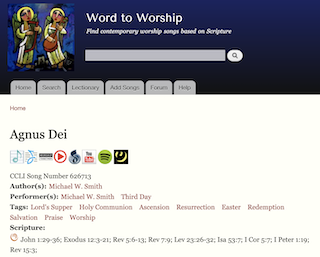

In [19]:
import requests
from bs4 import BeautifulSoup

In [ ]:

ccli_original["Themes"] = ""

for i in range(ccli_original.shape[0]):
    search = ccli_original["CCLI"].iloc[i]
    url = f"https://wordtoworship.com/search/node/{search}"
    req = requests.get(url, headers={"User-Agent": "XY"}).text
    sor = BeautifulSoup(req, "html.parser")
    soup = sor.find("h3", class_="title")
    try:
        link = [a['href'] for a in soup.find_all('a', href=True)][0]
        song_req = requests.get(link, headers={"User-Agent": "XY"}).text
        song_sor = BeautifulSoup(song_req, "html.parser")
        song_soup = song_sor.find("div", class_="field field-name-field-tags field-type-taxonomy-term-reference field-label-inline clearfix")
        themes = [a.text for a in song_soup.find_all('a')]
        ccli_original["Themes"].iloc[i] = themes
    except:
        pass


In [22]:
ccli_df = ccli_original
ccli_df.head()

Title  BPM     CCLI  \
0  Agnus Dei - Lord of All    69   626713   
1          You Are My World   74  3258174   
2                   Forever  120  7001228   
3           In Christ Alone   68  3350395   
4      How Great Is Our God   76  4348399   

                                              Themes  
0  [Lord's Supper, Holy Communion, Ascension, Res...  
1                       [Prayer, Surrender, Worship]  
2  [Adoration & Praise, Grace & Mercy, Resurrecti...  
3  [Hope, Security, Resurrection, Life of Jesus, ...  
4      [Hymn, Kingship, Majesty, Praise, Worthiness]

`ccli_df` will house all the data where theme information was found. 

In [23]:
ccli_df = ccli_df[ccli_df["Themes"] != ""]
ccli_df = ccli_df.reset_index(drop=True)
ccli_df

Title  BPM     CCLI  \
0   Agnus Dei - Lord of All    69   626713   
1           You Are My World   74  3258174   
2                    Forever  120  7001228   
3            In Christ Alone   68  3350395   
4       How Great Is Our God   76  4348399   
..                       ...  ...      ...   
76                  Promises   86  7149439   
77       Graves Into Gardens   70  7138219   
78            Hymn Of Heaven   71  7168994   
79         Here As In Heaven   69  7051506   
80         House Of The Lord   86  7168995   

                                               Themes  
0   [Lord's Supper, Holy Communion, Ascension, Res...  
1                        [Prayer, Surrender, Worship]  
2   [Adoration & Praise, Grace & Mercy, Resurrecti...  
3   [Hope, Security, Resurrection, Life of Jesus, ...  
4       [Hymn, Kingship, Majesty, Praise, Worthiness]  
..                                                ...  
76  [promises of God, God's faithfulness, Blessing...  
77  [Fulfillment, God's Love, Grace, Mercy, Praise...  
78  [Worship, Heaven, Hymn, Eternity, Revelation, ...  
79  [Kingdom of God, Kingdom of Heaven, Lord's Pra...  
80  [Celebration, Revival, Church, Acceptance, Gra...  

[81 rows x 4 columns]

Unfortunately, this further limits the data to solely 81 rows. This data however is very clean and can be analyzed much better than the original data. 

The code blocks below expand our data into a long format. While less visually appealing, this process makes machine learning algorithms much easier to implement. The lists of themes attached to each song title will be expanded into their own columns, and a `0` will refer to that title not having that theme, while `1` will mean that the song has that theme. 

In [29]:
theme_set = set()
for theme in ccli_df["Themes"]:
    for i in range(len(theme)):
        text = theme[i].lower()
        if "." in text: # some typos in the data
            texts = text.split(".")
            theme_set.update(texts)
        elif " & " in text:
            texts = text.split(" & ")
            theme_set.update(texts)
        else:
            theme_set.add(text)

theme_df = pd.DataFrame(columns=list(theme_set))
theme_df["Title"] = ccli_df["Title"]


#sets title as first column
titles = theme_df.pop('Title')
theme_df.insert(0, "Title", titles)
theme_df.head()

# initializes 0 for each theme
for i in range(theme_df.shape[0]):
    for theme in theme_set:
        theme_df.at[i, theme.lower()] = 0

In [30]:
ccli_themes = pd.merge(ccli_df, theme_df, how='left', on='Title')

In [31]:
for i in range(ccli_themes.shape[0]):
    list_themes = ccli_themes["Themes"].iloc[i]
    for theme in list_themes:
        if " & " in theme:
            themes = theme.split(" & ")
            for tag in themes: 
                ccli_themes.at[i, tag.lower()] = 1
        else:
            ccli_themes.at[i, theme.lower()] = 1

In [50]:
ccli_themes = ccli_themes.drop(columns=["CCLI", "Themes", "npursue", "healing. god's presence"]) 
#for bug fixing purposes

ccli_themes = ccli_themes.drop_duplicates()
ccli_themes = ccli_themes.reset_index(drop=True)
ccli_themes

Title  BPM revival palm sunday cross grace help christ  \
0   Agnus Dei - Lord of All    69       0           0     0     0    0      0   
1           You Are My World   74       0           0     0     0    0      0   
2                    Forever  120       0           0     0     1    0      0   
3            In Christ Alone   68       0           0     0     0    0      0   
4       How Great Is Our God   76       0           0     0     0    0      0   
..                       ...  ...     ...         ...   ...   ...  ...    ...   
76                  Promises   86       0           0     0     0    0      0   
77       Graves Into Gardens   70       0           0     0     1    0      0   
78            Hymn Of Heaven   71       0           0     0     0    0      0   
79         Here As In Heaven   69       0           0     0     0    0      0   
80         House Of The Lord   86       1           0     0     1    0      0   

   rejoice victor  ... holy is the lamb jesus name of jesus defender  \
0        0      0  ...                0     0             0        0   
1        0      0  ...                0     0             0        0   
2        0      0  ...                0     0             0        0   
3        0      0  ...                0     0             0        0   
4        0      0  ...                0     0             0        0   
..     ...    ...  ...              ...   ...           ...      ...   
76       0      0  ...                0     0             0        0   
77       0      0  ...                0     0             0        0   
78       0      0  ...                1     0             0        0   
79       0      0  ...                0     0             0        0   
80       0      0  ...                0     0             0        0   

   consecration singing overcome desert christian life exaltation  
0             0       0        0      0              0          0  
1             0       0        0      0              0          0  
2             0       0        0      0              0          0  
3             0       0        0      0              0          0  
4             0       0        0      0              0          0  
..          ...     ...      ...    ...            ...        ...  
76            0       0        0      0              0          0  
77            0       0        0      0              0          0  
78            0       0        0      0              0          0  
79            0       0        0      0              0          0  
80            0       0        0      0              0          0  

[81 rows x 187 columns]

In [33]:
df = ccli_themes #since df is shorter to write out than ccli_themes
df.to_excel("clean_data.xlsx", index=False)
df.head()

Title  BPM revival palm sunday npursue cross grace help  \
0  Agnus Dei - Lord of All    69       0           0       0     0     0    0   
1          You Are My World   74       0           0       0     0     0    0   
2                   Forever  120       0           0       0     0     1    0   
3           In Christ Alone   68       0           0       0     0     0    0   
4      How Great Is Our God   76       0           0       0     0     0    0   

  christ rejoice  ... holy is the lamb jesus name of jesus defender  \
0      0       0  ...                0     0             0        0   
1      0       0  ...                0     0             0        0   
2      0       0  ...                0     0             0        0   
3      0       0  ...                0     0             0        0   
4      0       0  ...                0     0             0        0   

  consecration singing overcome desert christian life exaltation  
0            0       0        0      0              0          0  
1            0       0        0      0              0          0  
2            0       0        0      0              0          0  
3            0       0        0      0              0          0  
4            0       0        0      0              0          0  

[5 rows x 188 columns]

Thus, we have cleaned and retrieved as much data as possible from the original messy data into a new data set called `df`, containing song `Title`, `BPM`, and themes. We can now begin setting up some machine learning models. 

## Part Two: Machine Learning Analysis

The field of data science is in practically unanimous agreement that the most difficult/tedious part of data analysis is the cleaning and preparation of the data sets. From this point on, it is a matter of picking a machine learning model and implementing that into our data set. 

Given the type of data we have, a clustering machine learning algorithm would be best to use. Clustering algorithms group variables of data into a certain number of groups, or clusters, where all items in the clusters have similar characteristics. Below, we will use the KMeans algorithm to group the data based on similar themes. 

We will first remove "rare" themes from our data set, defining rare to mean that fewer than 4 songs share that theme. 

In [34]:
rare_cols = []
for col in df.columns:
    if col != "Title" and col != "BPM":
        if sum(df[col]) < 4:
            rare_cols.append(col)

In [35]:
df = df.drop(columns=rare_cols)
df.head()

Title  BPM cross grace salvation worship praise  \
0  Agnus Dei - Lord of All    69     0     0         1       1      1   
1          You Are My World   74     0     0         0       1      0   
2                   Forever  120     0     1         0       0      1   
3           In Christ Alone   68     0     0         0       0      0   
4      How Great Is Our God   76     0     0         0       0      1   

  declaration resurrection freedom  ... victory promise surrender commitment  \
0           0            1       0  ...       0       0         0          0   
1           0            0       0  ...       0       0         1          0   
2           0            1       0  ...       0       0         0          0   
3           0            1       0  ...       0       0         0          0   
4           0            0       0  ...       0       0         0          0   

  mercy sacrifice prayer trust jesus name of jesus  
0     0         0      0     0     0             0  
1     0         0      1     0     0             0  
2     1         1      0     0     0             0  
3     0         0      0     0     0             0  
4     0         0      0     0     0             0  

[5 rows x 37 columns]

In [36]:
df.shape[1] # number of columns

37

Note that this limits us to 37 columns, so 35 themes (one column is "Title" and one is "BPM"). Now we can start to define our model with 8 clusters. The number 8 was chosen because I want groups of about 10 related songs. 

In [37]:
from sklearn.cluster import KMeans

# 1. Defining the model: KMeans with 8 clusters
km = KMeans(n_clusters=8)

In [38]:
# 2. Fitting the model to the data

# gets theme columns to create a df of just themes
themes = []
for col in df.columns:
    if col != "Title" and col != "BPM":
        themes.append(col)
        
theme_df = pd.DataFrame()
for theme in themes: 
    theme_df[theme] = df[theme]

    
# fitting the model to our theme data
km.fit(theme_df)
centroids = km.cluster_centers_ # will be demonstrated later 

theme_df['Cluster'] = km.predict(theme_df)

In [39]:
theme_df['Cluster']

0     2
1     3
2     5
3     2
4     7
     ..
76    0
77    3
78    2
79    7
80    0
Name: Cluster, Length: 81, dtype: int32

A couple things to note thus far:
* We have temporarily abandoned our BPM data. This model will group similar songs solely by their themes. If BPM data were to be included, the BPM and theme data would have to be normalized so that the BPM data (ranges from approx. 60 to 150) does not count as more important than theme data (0 or 1). Also, the output would not just group songs by their themes, but by BPM as well. This result does not interest me, as I would care firstly about the theme of a song when creating a worship set, but it is worth mentioning that using BPM data is a possible variation.

* The "output" of this model is `theme_df`, which is a df of all the themes plus a column listing the cluster of each song. Now it is just a matter of extracting those cluster groups. 

In [40]:
for i in range(8):
    print("Cluster {}:".format(i))
    print(centroids[i])
    print("----------")
    print()

Cluster 0:
[-1.38777878e-17  1.00000000e-01  0.00000000e+00  7.00000000e-01
  1.00000000e+00  1.00000000e-01 -5.55111512e-17  0.00000000e+00
 -1.38777878e-17  1.00000000e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e-01  1.00000000e-01 -4.16333634e-17  2.00000000e-01
  0.00000000e+00  2.00000000e-01  6.00000000e-01  0.00000000e+00
  1.00000000e-01  3.00000000e-01  0.00000000e+00  1.00000000e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.00000000e-01  0.00000000e+00  2.00000000e-01]
----------

Cluster 1:
[0.         0.         0.         0.33333333 0.         0.33333333
 0.33333333 0.         0.66666667 0.33333333 0.         0.
 0.         0.         0.         1.         0.         0.
 0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
----------

Cluster 2:
[ 1.11111111e

The above code prints out the "centroids". These "points" are what define each cluster. As in, items in Cluster 7 would be as similar as possible to: 
* 0 of theme 0 
* 0 of theme 1 

...
* 0.125 of theme 3, etc.

Now, we can import the cluster data back to the data frame to start presenting the findings. 

In [41]:
df['Cluster'] = theme_df['Cluster']

In [42]:
def cluster_getter(df, num):
    '''
    This function takes a df and an integer to output a cluster list
    '''
    cluster_list = []
    for i in range(df.shape[0]):
        if df['Cluster'].iloc[i] == num:
            cluster_list.append(df["Title"].iloc[i])
    return cluster_list

In [43]:
clusters = dict()
for i in range(8): 
    cluster_list = cluster_getter(df, i)
    clusters[i] = cluster_list

In [44]:
for num in clusters:
    print("---------------------------")
    print("Group {}: ".format(num))
    for i in range(len(clusters[num])):
        print(clusters[num][i])
    print()
        

---------------------------
Group 0: 
Lord I Need You
All The Poor And Powerless
With Everything
Only King Forever
At Your Name
Way Maker
Raise A Hallelujah
I Give You My Heart
Promises
House Of The Lord

---------------------------
Group 1: 
Glorious (Paul Baloche)
Come Lord Jesus (Even So Come)
Open Up The Heavens

---------------------------
Group 2: 
Agnus Dei - Lord of All 
In Christ Alone
Happy Day
Your Great Name
O Praise The Name (Anástasis)
Glorious Day
Jerusalem
Overcome
Hymn Of Heaven

---------------------------
Group 3: 
You Are My World
The Stand
Came To My Rescue
Arms Open Wide
Give Me Faith
Lay Me Down
Goodness Of God / Bunatatea Ta
From The Inside Out
Graves Into Gardens

---------------------------
Group 4: 
All Because Of Jesus
O Come To The Altar
Who You Say I Am
Living Hope
No Longer Slaves

---------------------------
Group 5: 
Forever
Forever
This I Believe
King Of Kings

---------------------------
Group 6: 
Jesus Paid It All
Break Every Chain
What A Beautiful N

In [45]:
df.to_excel("theme_clusters.xlsx", index=False)

There it is! The code above simply formats the results to print out nicely as seen above. Each of the groups have similar themes. Notice how the songs from Group 6 below all have common themes of 'Second Coming'. 

In [48]:
ccli_df.set_index("Title", inplace=True)

for song in clusters[1]:
    print(song + ":")
    print(ccli_df["Themes"].loc[song])
    print()

Glorious (Paul Baloche):
['Declaration', 'Faith', 'Glory', 'Resurrection', 'Second Coming']

Come Lord Jesus (Even So Come):
['Advent', 'Second Coming']

Open Up The Heavens:
['Heaven', 'Second Coming', 'Worship', 'Glory', 'Power', 'Singing', 'Call to Worship', 'Presence', 'Invocation']



## Conclusion 

In summary, this project began by downloading and processing my church's Planning Center song data. Realizing that lots of work would be needed, all variables except the Title and BPM were abandoned. The data was indexed to only contain songs that were in English, had a BPM, and contained a CCLI number. Given that information, theme variables were web scraped and the result was a data set containing title, BPM, and song variables. 

With that data, the KMeans algorithm was used to create 8 groups of songs with closely-linked themes. Thus, all the cleaning and modeling resulted in the following visualization (created using Tableau): 

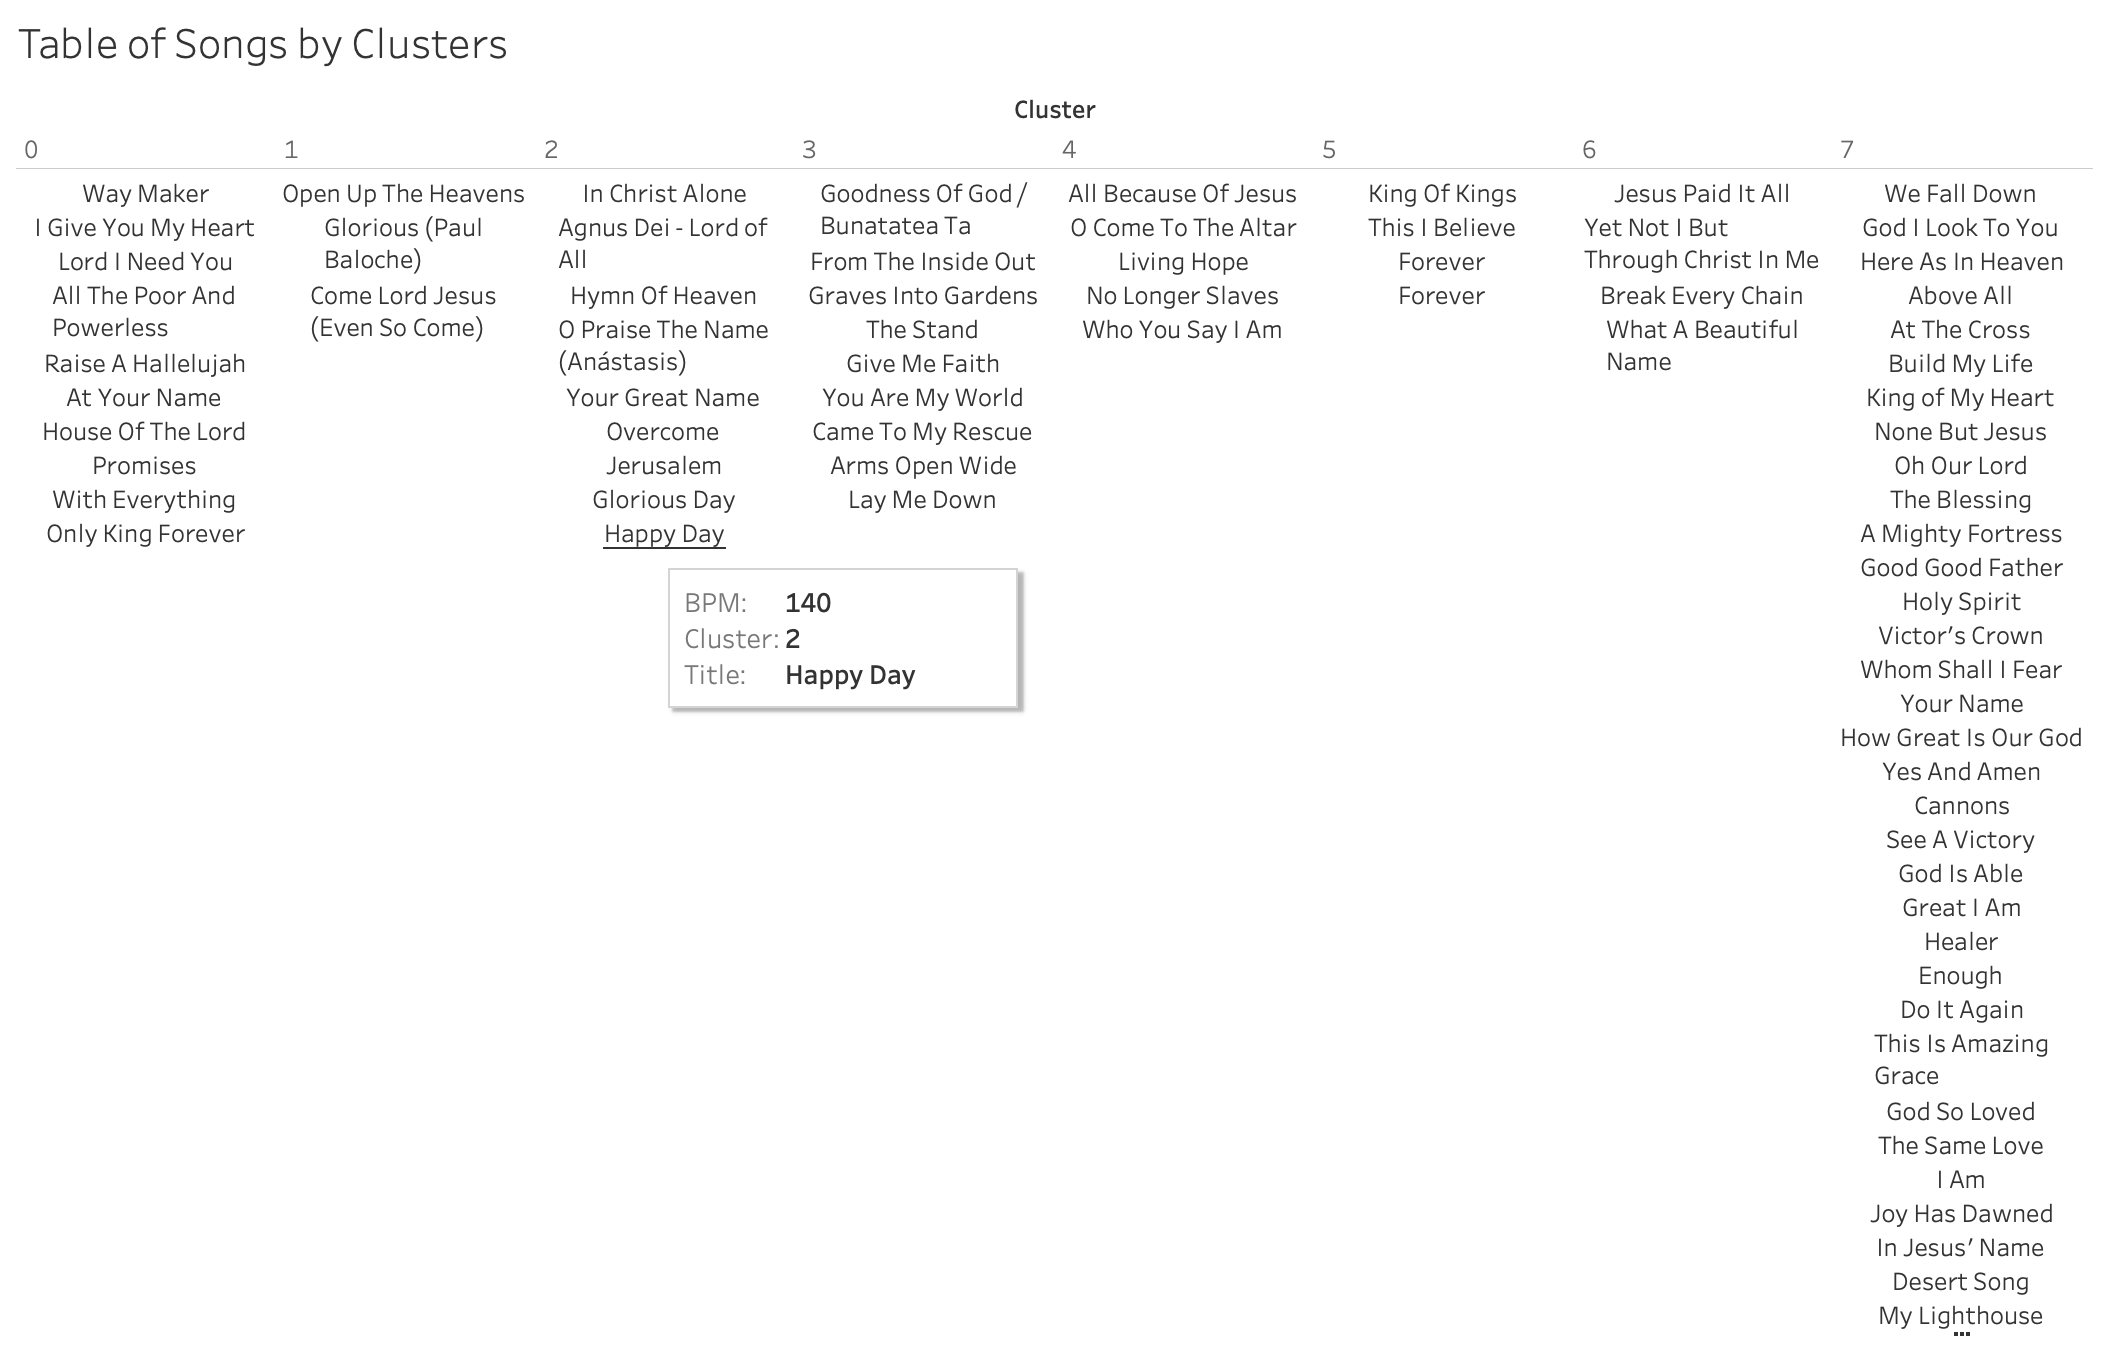

## Reflection

While I am very satisfied with the result given the context of the extremely poor data to start with, the overwhelming feeling throughout the entirety of the project was that I really wished I had better data. In the end, I am confident that the implementation of machine learning models used above would have produced even better results with improved data. 

Given better data and time, I would have loved to expand on this project by creating a user interface by which users would input the theme of a preacher's message (say, "confession") and the program would output a 4-5 songs that relate to that theme and would be listed in an order matching the flow of the service (i.e. slower to faster tempo). 

## References 
* akashkumarsen4. “Scrape Google Search Results Using Python Beautifulsoup.” GeeksforGeeks, GeeksforGeeks, 29 Dec. 2020, https://www.geeksforgeeks.org/scrape-google-search-results-using-python-beautifulsoup/. 
* Khushijain. “K-Means Clustering: Python Implementation from Scratch.” Medium, Towards Data Science, 3 July 2021, https://medium.com/nerd-for-tech/k-means-python-implementation-from-scratch-8400f30b8e5c. 
* Pietro, Mauro Di. “Text Analysis &amp; Feature Engineering with NLP.” Medium, Towards Data Science, 15 Mar. 2022, https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d. 